In [17]:
import pandas as pd       
import numpy as np 
import math
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from math import e
%matplotlib inline
import seaborn as sns

In [18]:
# Se procedio llamar los datos guardados en la plataforma GIT-HUB
datos = pd.read_csv("https://raw.githubusercontent.com/diego304530/dataset-drogas/master/encuestaBinaria.csv", error_bad_lines=False)
datos.drop([ 'Unnamed: 0'], axis=1, inplace=True)

In [19]:
datos.head(5)

,Estrato,Genero,Edad,Grado,Zona,Deporte,Trabaja,Invitacion_drogas,Consecuencias_consumo,Padres_alcohol,...,Timido,Impulsivo,Calle,Casa,Colegio.1,Con_pareja_sentimental,Fiestas,No_consumido,Parque,Paseo
0,3,0,16,11,1,1,0,0,1,2,...,0,0,0,0,0,0,0,1,0,0
1,5,1,16,10,1,1,0,1,1,2,...,1,0,0,0,0,0,0,1,0,0
2,4,0,16,10,1,1,1,1,1,3,...,0,0,0,0,0,0,1,0,0,0
3,4,0,16,11,1,1,0,1,1,2,...,0,0,0,0,0,0,1,0,0,0
4,3,1,16,11,1,0,0,0,1,2,...,1,0,0,1,0,0,0,0,0,0


In [20]:
# Procedemos a cambiar el unico dato de tipo float al tipo de dato entero
datos.A_que_edad = datos.A_que_edad.astype(int)
datos.dtypes

Estrato                          int64
Genero                           int64
Edad                             int64
Grado                            int64
Zona                             int64
Deporte                          int64
Trabaja                          int64
Invitacion_drogas                int64
Consecuencias_consumo            int64
Padres_alcohol                   int64
Reaccion_padres                  int64
Cigarrillo                       int64
Consume_droga                    int64
A_que_edad                       int32
Atencion_padres                  int64
Conocimiento_amistades_padres    int64
Continua                         int64
Grados_perdidos                  int64
Recreo                           int64
Acoso_escolar                    int64
Acoso_sexual                     int64
Relacion_familiar                int64
Limitaciones                     int64
Sexualidad                       int64
Habitacion_compartida            int64
Perdida_familiar         

In [21]:
#EJECUTAMOS EL COMANDO PARA OBSERVAR CUANTAS PERSONAS CONSUMEN DROGAS
print(datos.groupby('Consume_droga').size())


Consume_droga
0    236
1     44
dtype: int64


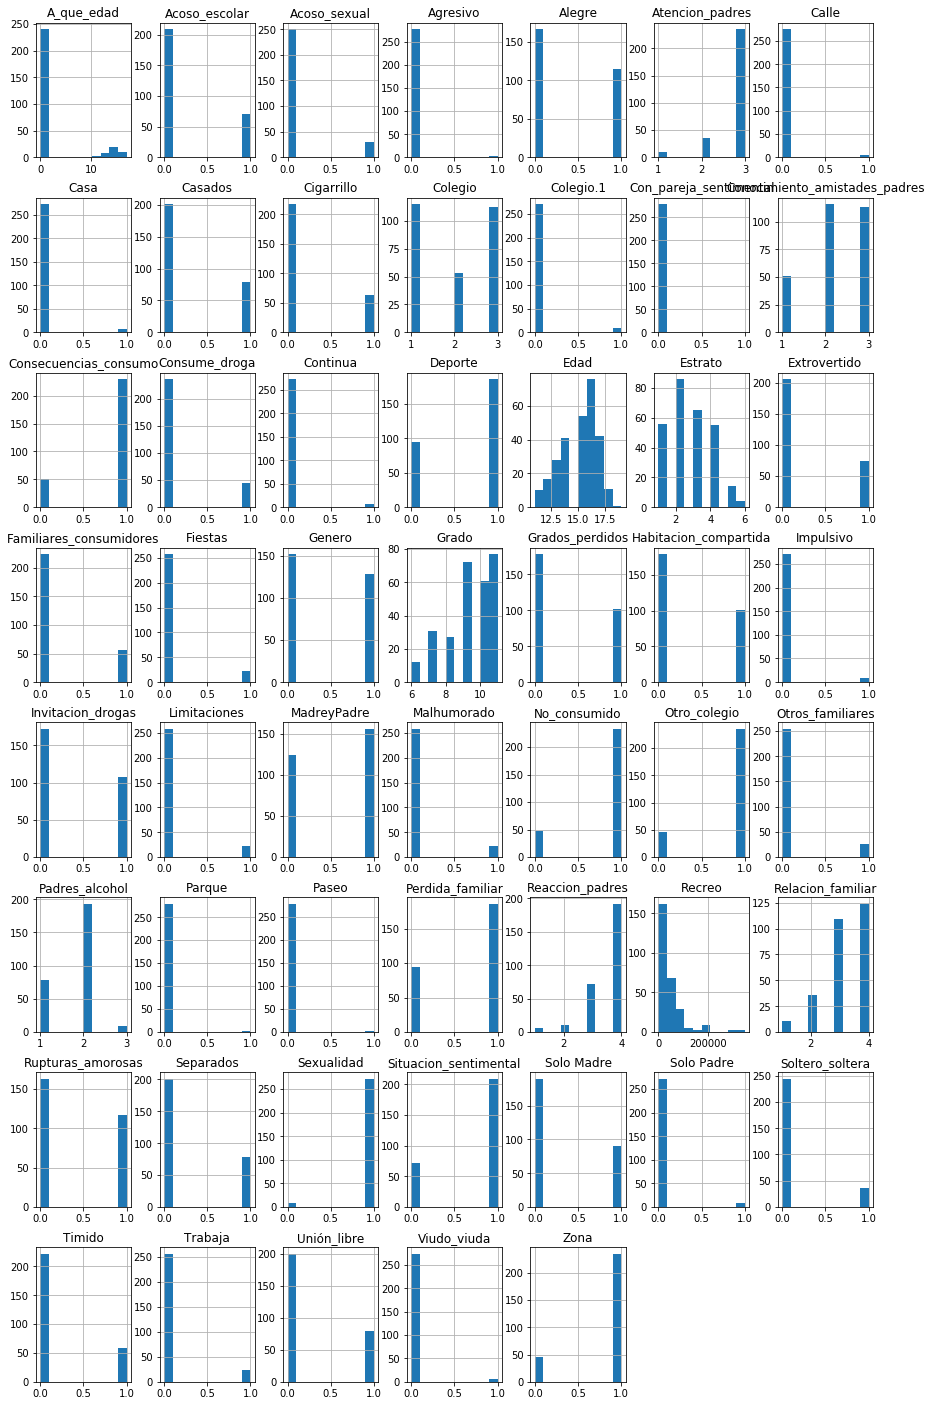

In [22]:
# graficamos las variables para seleccionar las que tengan menos interaccion 
#de respuesta y disminuir las variables para una mayor eficacia de los modelos 
plt.rcParams['figure.figsize']= [15.,25]
datos.drop([],1).hist()
plt.show()

In [23]:
# eliminamos las variables que no aportan informacion al modelo y las eliminamos
datos.drop(['A_que_edad', 'Agresivo','Calle', 'Casa', 'Colegio.1','Con_pareja_sentimental', 
            'Continua', 'Impulsivo','Parque','Paseo', 'Sexualidad', 'Viudo_viuda', 'Solo Padre','No_consumido','Fiestas'], axis=1 ,inplace=True)


In [24]:
# se realizara la correlacion de los datos para identificar los datos que no sirven para realizar el modelo 
#de prediccion y conocer
# cuales son los datos con mayor correlacion con la variable dependiente Consume_droga
def calcular_pvalue(datos):
    datos = datos.dropna()._get_numeric_data()
    datoscols = pd.DataFrame(columns=datos.columns)
    pvalues = datoscols.transpose().join(datoscols, how='outer')
    for r in datos.columns:
        for c in datos.columns:
            pvalues[r][c] = round(pearsonr(datos[r], datos[c])[1], 4)
    return pvalues
pval = calcular_pvalue(datos) 
# Vemos la correlacion y su significancia
rho = datos.corr()

rho = rho.round(3)

# create three masks
r1 = rho.applymap(lambda x: '{}*'.format(x))
r2 = rho.applymap(lambda x: '{}**'.format(x))
r3 = rho.applymap(lambda x: '{}***'.format(x))

# apply them where appropriate
rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r2)
rho = rho.mask(pval<=0.01,r3)
rho

,Estrato,Genero,Edad,Grado,Zona,Deporte,Trabaja,Invitacion_drogas,Consecuencias_consumo,Padres_alcohol,...,Otros_familiares,Solo Madre,Casados,Separados,Soltero_soltera,Unión_libre,Alegre,Extrovertido,Malhumorado,Timido
Estrato,1.0***,0.088,0.043,0.104*,0.234***,0.2***,0.019,0.184***,-0.033,0.115*,...,-0.115*,0.063,0.156***,0.085,-0.024,-0.21***,-0.137**,0.16***,-0.086,0.089
Genero,0.088,1.0***,-0.088,-0.04,-0.086,0.242***,0.18***,0.068,0.053,-0.064,...,-0.071,-0.094,0.03,-0.145**,0.012,0.118**,-0.075,0.003,-0.028,0.044
Edad,0.043,-0.088,1.0***,0.8***,0.048,-0.101*,0.143**,0.319***,0.047,0.08,...,0.066,0.009,0.016,0.03,0.049,-0.104*,-0.198***,0.093,0.018,0.073
Grado,0.104*,-0.04,0.8***,1.0***,0.023,-0.025,0.09,0.378***,0.013,0.079,...,-0.079,0,0.106*,-0.029,-0.048,-0.074,-0.286***,0.162***,-0.019,0.177***
Zona,0.234***,-0.086,0.048,0.023,1.0***,0.018,-0.074,0.107*,0.024,-0.021,...,-0.095,0.093,0.101*,0.015,0.081,-0.175***,-0.073,0.086,0.019,-0.016
Deporte,0.2***,0.242***,-0.101*,-0.025,0.018,1.0***,0.11*,0.051,0.063,-0.018,...,-0.111*,0.02,0.009,-0.058,-0.021,0.065,-0.011,0.135**,-0.073,-0.047
Trabaja,0.019,0.18***,0.143**,0.09,-0.074,0.11*,1.0***,0.203***,-0.024,-0.002,...,0.122**,0.144**,-0.107*,0.063,-0.003,0.004,-0.202***,0.077,0.005,0.032
Invitacion_drogas,0.184***,0.068,0.319***,0.378***,0.107*,0.051,0.203***,1.0***,-0.09,0.068,...,-0.102*,0.13**,-0.024,0.106*,0.068,-0.111*,-0.343***,0.174***,0.096,0.084
Consecuencias_consumo,-0.033,0.053,0.047,0.013,0.024,0.063,-0.024,-0.09,1.0***,-0.099*,...,0.117*,-0.039,-0.039,-0.039,0.04,0.047,-0.069,0.174***,-0.106*,-0.061
Padres_alcohol,0.115*,-0.064,0.08,0.079,-0.021,-0.018,-0.002,0.068,-0.099*,1.0***,...,0.035,0.033,-0.088,0.087,-0.088,0.09,0.06,0.004,0.064,-0.065


In [25]:
# se procedio a  eliminar las varibales independientes que tienen una correlacion alta entre ellas para que no afecten los modelos de prediccion 
datos.drop(['Grado','Relacion_familiar','Conocimiento_amistades_padres','Estrato'], axis=1, inplace=True)


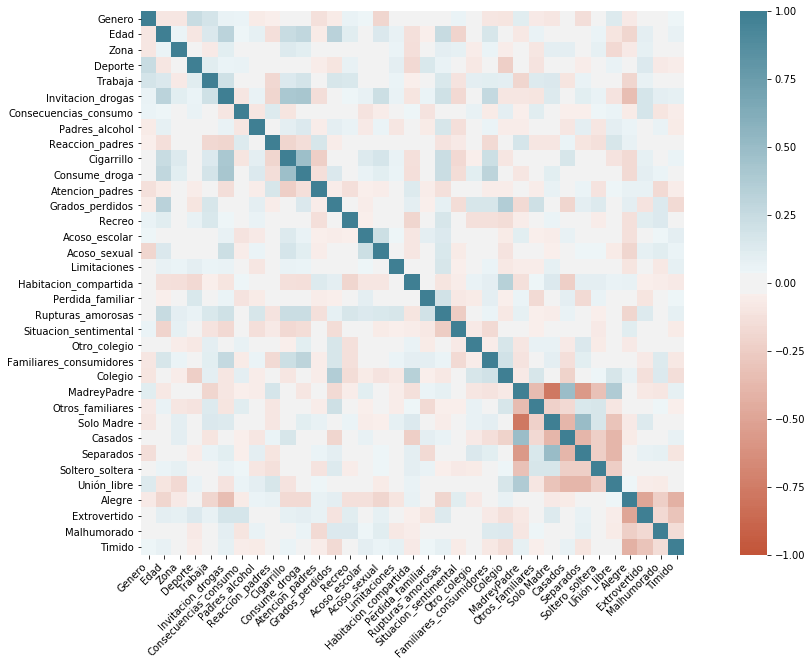

In [26]:
# realizamos una grafica de colores que indican segun su color la correlacion 
# de las variables independientes con la variable dependiente

plt.rcParams['figure.figsize'] = (20.0, 10.0)
corr = datos.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

In [35]:
datos.drop(['Recreo'], axis=1, inplace=True)


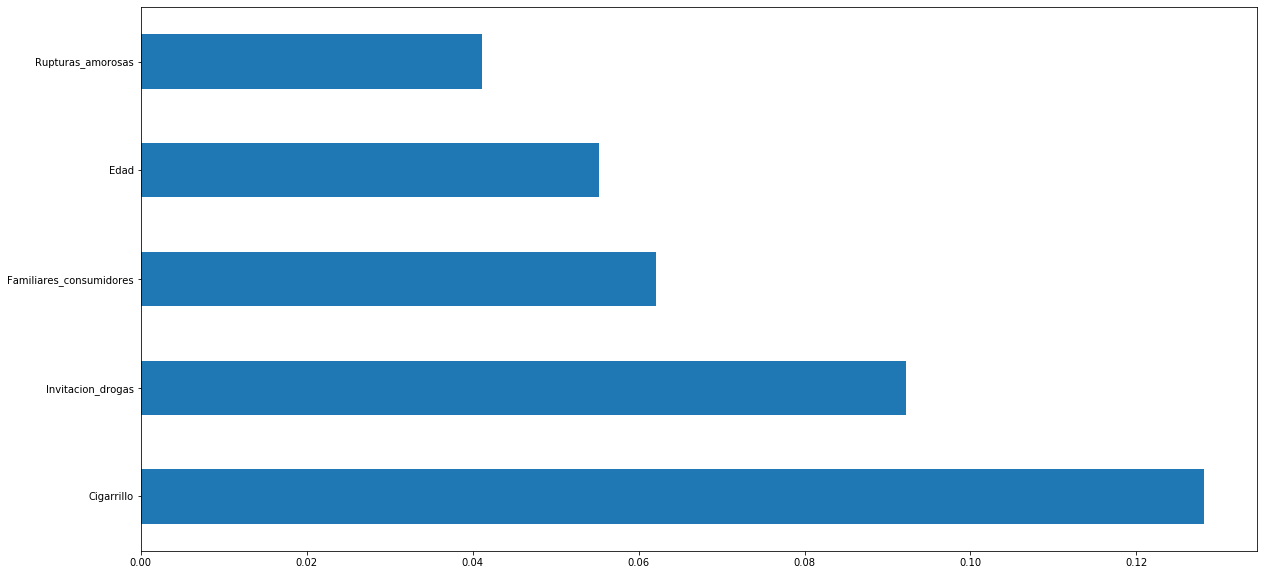

In [36]:
 
#FEATURE SELECTION

# columnas independientes
X = datos.iloc[:, datos.columns !='Consume_droga']

 # Columna objetivo
y = datos.Consume_droga 

model = ExtraTreesClassifier()
model.fit(X,y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show(1)


C:\Users\david perez\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\david perez\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\david perez\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\david perez\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no eff

LR: 0.875116 (0.033161)
LDA: 0.853608 (0.028404)
KNN: 0.868101 (0.037072)
CART: 0.839500 (0.028466)
NB: 0.857154 (0.031663)


C:\Users\david perez\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.836031 (0.035110)


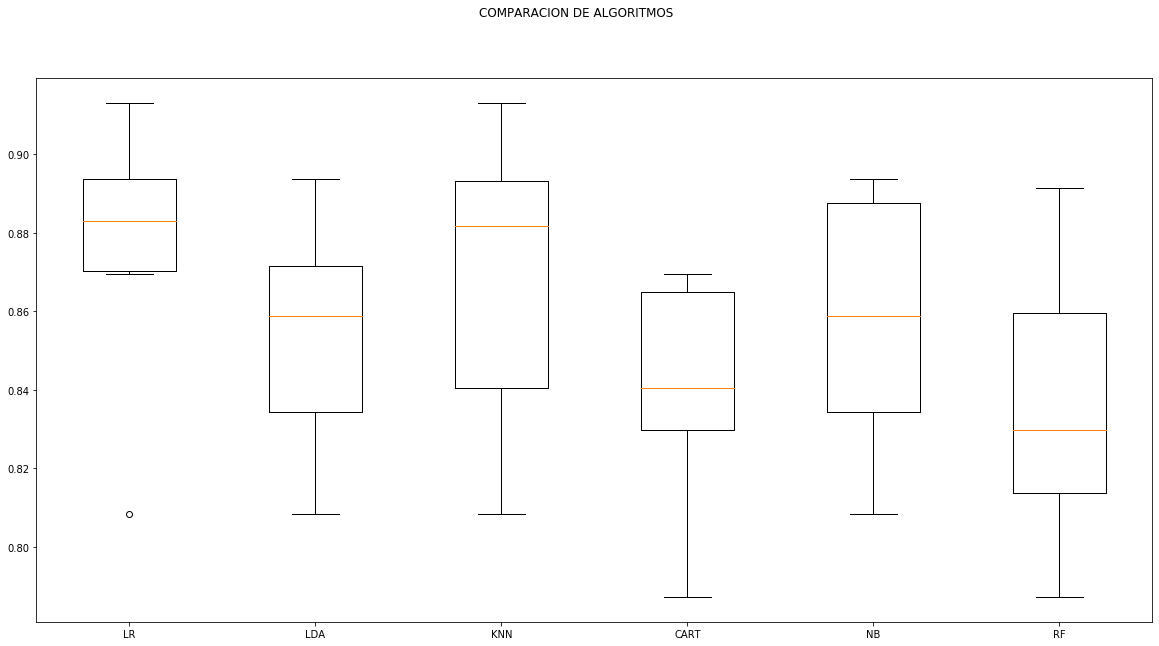

In [16]:
# LUEGO DE SELECIONAR LAS VARIABLES MAS FACTIBLES PARA LA PREDICCION LAS UTILZAMOS PARA INCORPORARLAS
#EN LOS DIFERENTES MODELOS 
feature_names = ['Cigarrillo','Invitacion_drogas','Familiares_consumidores','Edad','Rupturas_amorosas']
X = datos[feature_names]
Y = datos['Consume_droga']
dataframe = datos
array = dataframe.values
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
# models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=6, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('COMPARACION DE ALGORITMOS')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [83]:
model = linear_model.LogisticRegression()
model.fit(X,Y)
print("precision de predicciones = ",model.score(X,Y))
validation_size = 0.70
from sklearn.model_selection import train_test_split

x_train,x_validation,y_train,y_validation = model_selection.train_test_split(X,Y, test_size = validation_size )
nombre= "regresion logistica"
muestra = model_selection.KFold(n_splits=10, random_state=seed)
cv_results = model_selection.cross_val_score(model,x_train, y_train, cv=muestra, scoring= 'accuracy')
# msg = "%s: %f (%f)" %(nombre,cv_SSSSresults.mean(), cv_results.std())
#print(msg)

predictions = model.predict(x_validation)
print("exactitud de predicion : ", accuracy_score(y_validation,predictions))
#print(confusion_matrix(y_validation,predictions))


precision de predicciones =  0.8785714285714286
exactitud de predicion :  0.8979591836734694


C:\Users\david perez\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [37]:
def algoritmo(a,b,c,d,e):
    import pandas
    from sklearn import model_selection
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    import pickle
    import pandas as pd
    from sklearn.metrics import classification_report
    url = "https://raw.githubusercontent.com/diego304530/dataset-drogas/master/encuestaBinaria.csv"
    names = ['Cigarrillo','Invitacion_drogas','Familiares_consumidores','Edad','Rupturas_amorosas']
    dataframe = pandas.read_csv(url)
    array = dataframe.values
    X = dataframe[names]
    Y = array[:,13]
    test_size = 0.9
    seed = 7
    validation_size = 0.70
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y, test_size = validation_size )
    # Fit the model on training set
    model = LogisticRegression()
    model.fit(X, Y)

    result = model.score(X_test, Y_test)

    DatosConsola = pd.DataFrame({'Cigarrillo':[a],'Invitacion_drogas':[b],'Familiares_consumidores':[c], 'Edad':[d],'Rupturas_amorosas':[e],})
    print("posible a consumir droga", int(model.predict(DatosConsola)), " porcentaje de acierto: ", round(result*100),"%")
    

In [40]:
algoritmo(1,1,0,16,1)

posible a consumir droga 1  porcentaje de acierto:  90.0 %
